In this notebook we tried to create our clusters using minmax scaler and rebuilding the variables kids_home and teens_home to a new one that is the sum of those (variables not used: "customer_name", "customer_birthdate", "loyalty_card_number", "teens_home", "kids_home"). Clusters showed a high influence of binary variables.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from minisom import MiniSom
import umap.umap_ as umap

from dendogram_func import plot_dendrogram
from silhouette import plot_silhouette
from dbscan_auxiliary_func import get_kdist_plot
from visualization_umap import visualize_dimensionality_reduction_umap
from radar_plot import create_radar_chart
from hierarchical_func import fit_and_predict_clusters

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the datasets and looking ate them

In [2]:
customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")

C:\Users\joaof\AppData\Local\Temp\ipykernel_13364\3321492438.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")


In [3]:
customer_info

customer_name customer_gender  customer_birthdate  \
customer_id                                                           
39634               David Frink            male 1964-05-15 22:34:00   
43460             Belinda Terry          female 1988-03-26 23:06:00   
23937             Evelyn Calico          female 1969-04-13 18:07:00   
2431                Ora Boggess          female 1941-06-15 03:26:00   
10090             Lonnie Hopson            male 2001-12-18 03:03:00   
...                         ...             ...                 ...   
48487           Amelia Crawford          female 1983-08-28 11:43:00   
24856              Silvia Ramos          female 1992-09-21 19:16:00   
21373             Addie Coronel          female 1994-02-20 05:58:00   
19527            Msc. Mary Ross          female 1989-08-06 16:39:00   
5120         Bsc. Milton Friend            male 1957-06-19 10:53:00   

             kids_home  teens_home  number_complaints  \
customer_id                                             
39634              1.0         1.0                1.0   
43460              1.0         0.0                1.0   
23937              0.0         1.0                1.0   
2431               0.0         0.0                0.0   
10090              0.0         0.0                0.0   
...                ...         ...                ...   
48487              1.0         1.0                0.0   
24856              1.0         1.0                1.0   
21373              0.0         0.0                0.0   
19527              1.0         0.0                1.0   
5120               2.0         0.0                2.0   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                            2.0                   18306.0   
43460                            2.0                    5015.0   
23937                            3.0                    3097.0   
2431                             1.0                   10825.0   
10090                            1.0                     697.0   
...                              ...                       ...   
48487                            1.0                    7189.0   
24856                            1.0                   11238.0   
21373                            1.0                    6059.0   
19527                            1.0                    3098.0   
5120                             1.0                    6869.0   

             lifetime_spend_electronics  typical_hour  ...  \
customer_id                                            ...   
39634                            7106.0          17.0  ...   
43460                            1334.0           8.0  ...   
23937                            4073.0          10.0  ...   
2431                              207.0          17.0  ...   
10090                             570.0           NaN  ...   
...                                 ...           ...  ...   
48487                            6293.0          17.0  ...   
24856                           11490.0          12.0  ...   
21373                             241.0          12.0  ...   
19527                             425.0           6.0  ...   
5120                             1554.0          10.0  ...   

             lifetime_spend_fish  lifetime_spend_hygiene  \
customer_id                                                
39634                     4056.0                  2174.0   
43460                     1925.0                  2115.0   
23937                     2347.0                  1306.0   
2431                       151.0                    53.0   
10090                      172.0                   587.0   
...                          ...                     ...   
48487                     3779.0                  1748.0   
24856                     3893.0                  1621.0   
21373                      142.0                   179.0   
19527                     

In [4]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customer_name                            43631 non-null  object        
 1   customer_gender                          43631 non-null  object        
 2   customer_birthdate                       43631 non-null  datetime64[ns]
 3   kids_home                                43107 non-null  float64       
 4   teens_home                               42610 non-null  float64       
 5   number_complaints                        42977 non-null  float64       
 6   distinct_stores_visited                  42322 non-null  float64       
 7   lifetime_spend_groceries                 43631 non-null  float64       
 8   lifetime_spend_electronics               43631 non-null  float64       
 9   typical_hour                             

In [5]:
customer_info.iloc[:,20:22].info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year_first_transaction  43631 non-null  float64
 1   loyalty_card_number     24654 non-null  float64
dtypes: float64(2)
memory usage: 1022.6 KB


In [6]:
customer_info.duplicated().sum()

0

# Some visualizations

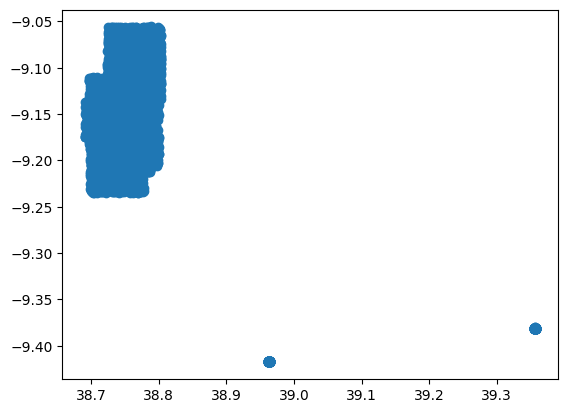

In [7]:
#Plotting longitude and latitude
plt.scatter(x = customer_info["latitude"], y= customer_info["longitude"])
plt.show()

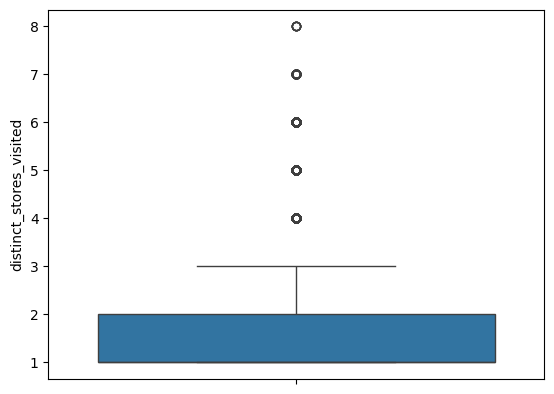

In [8]:
sns.boxplot(data = customer_info, y = "distinct_stores_visited")
plt.show()

In [9]:
customer_info[["lifetime_spend_fish"]]

lifetime_spend_fish
customer_id                     
39634                     4056.0
43460                     1925.0
23937                     2347.0
2431                       151.0
10090                      172.0
...                          ...
48487                     3779.0
24856                     3893.0
21373                      142.0
19527                        0.0
5120                      1221.0

[43631 rows x 1 columns]

In [10]:
customer_info[["lifetime_spend_fish"]].value_counts()

lifetime_spend_fish
1.0                    3298
0.0                    2624
2.0                     865
3.0                     101
318.0                    42
                       ... 
3079.0                    1
3077.0                    1
3067.0                    1
3065.0                    1
50381.0                   1
Name: count, Length: 4770, dtype: int64

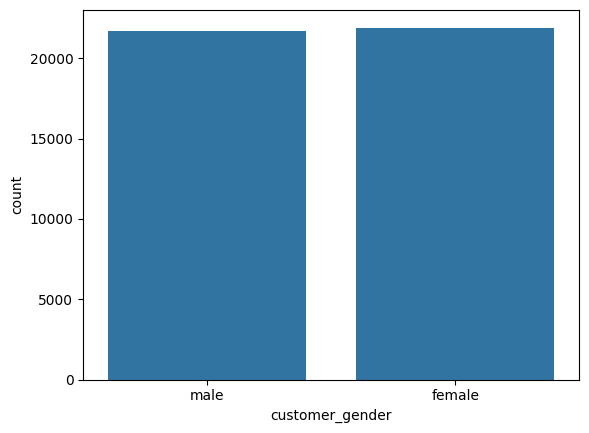

In [11]:
sns.countplot(x='customer_gender', data=customer_info)
plt.show()

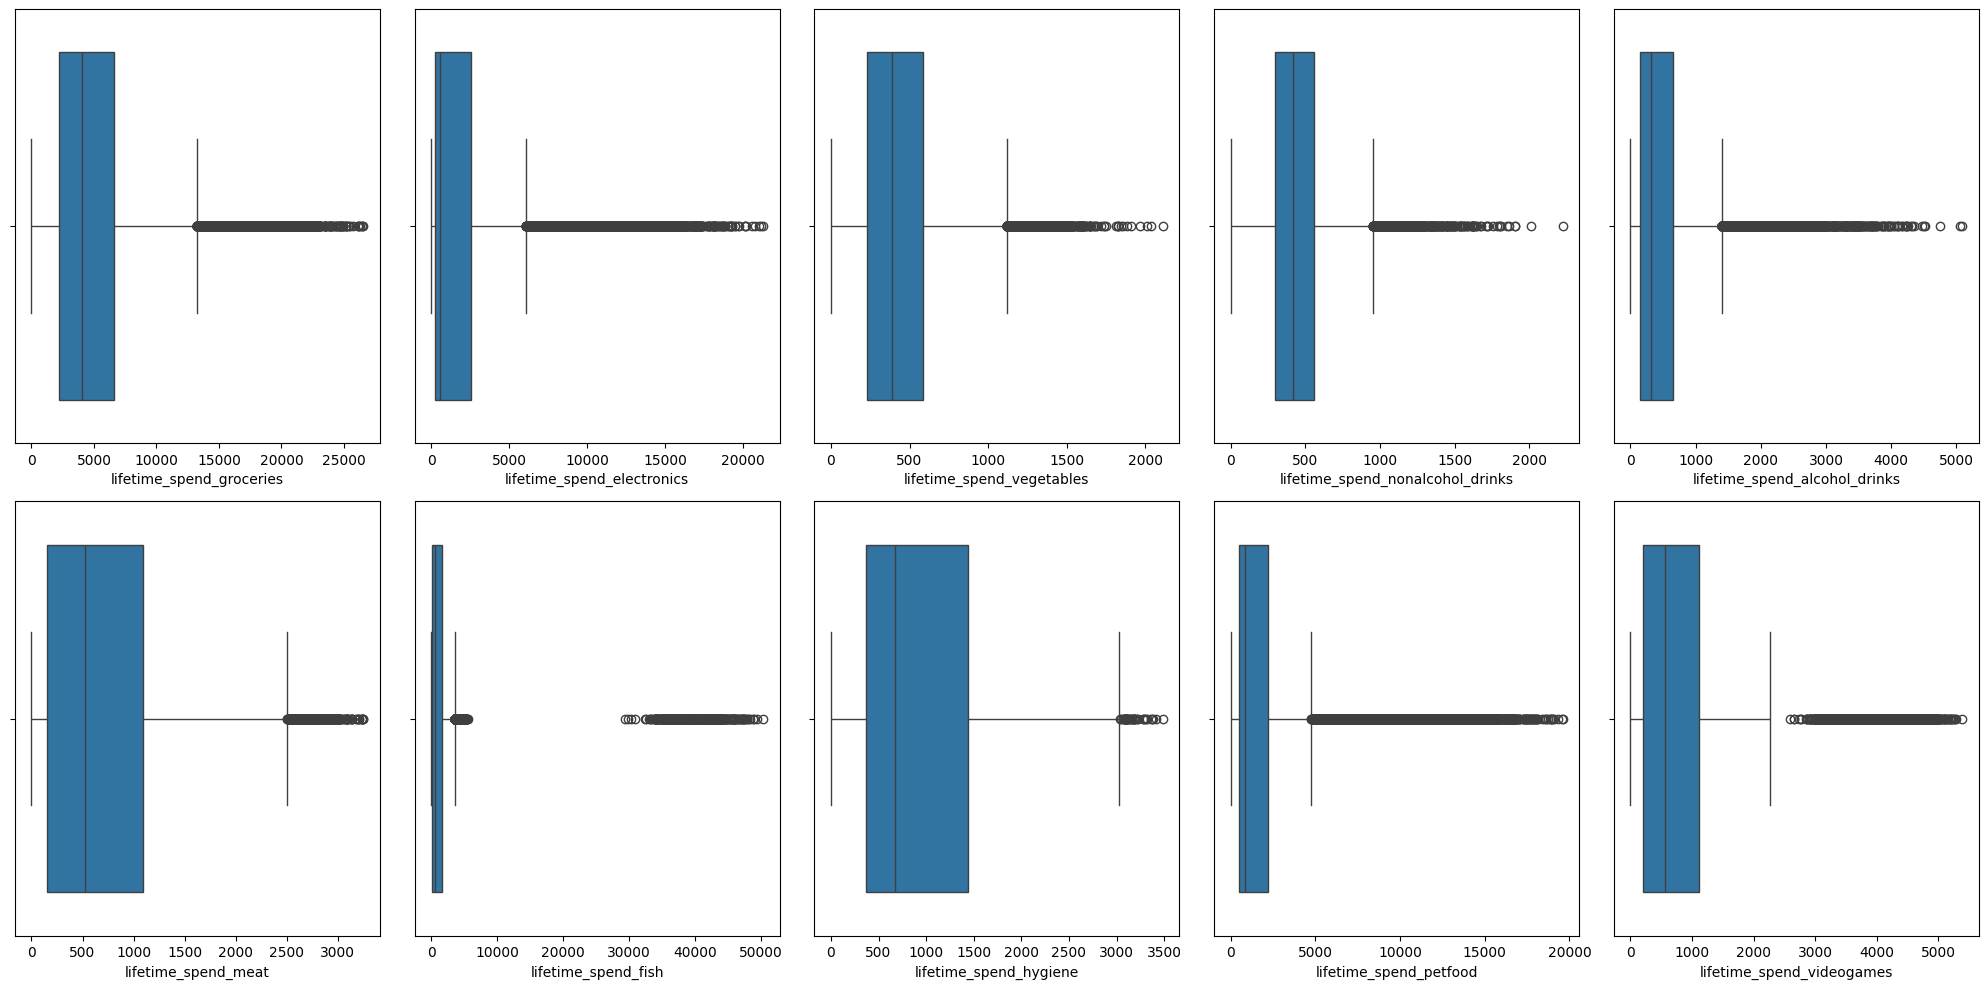

In [15]:
columns = ['lifetime_spend_groceries','lifetime_spend_electronics', 'lifetime_spend_vegetables',
           'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
            'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
             'lifetime_spend_petfood', 'lifetime_spend_videogames']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, column in enumerate(columns):
        if i// 5 == 0:
                sns.boxplot(x=customer_info[column], ax=axes[0][i])
        else:
                sns.boxplot(x=customer_info[column], ax=axes[1][i-5])
plt.tight_layout()   
plt.show()

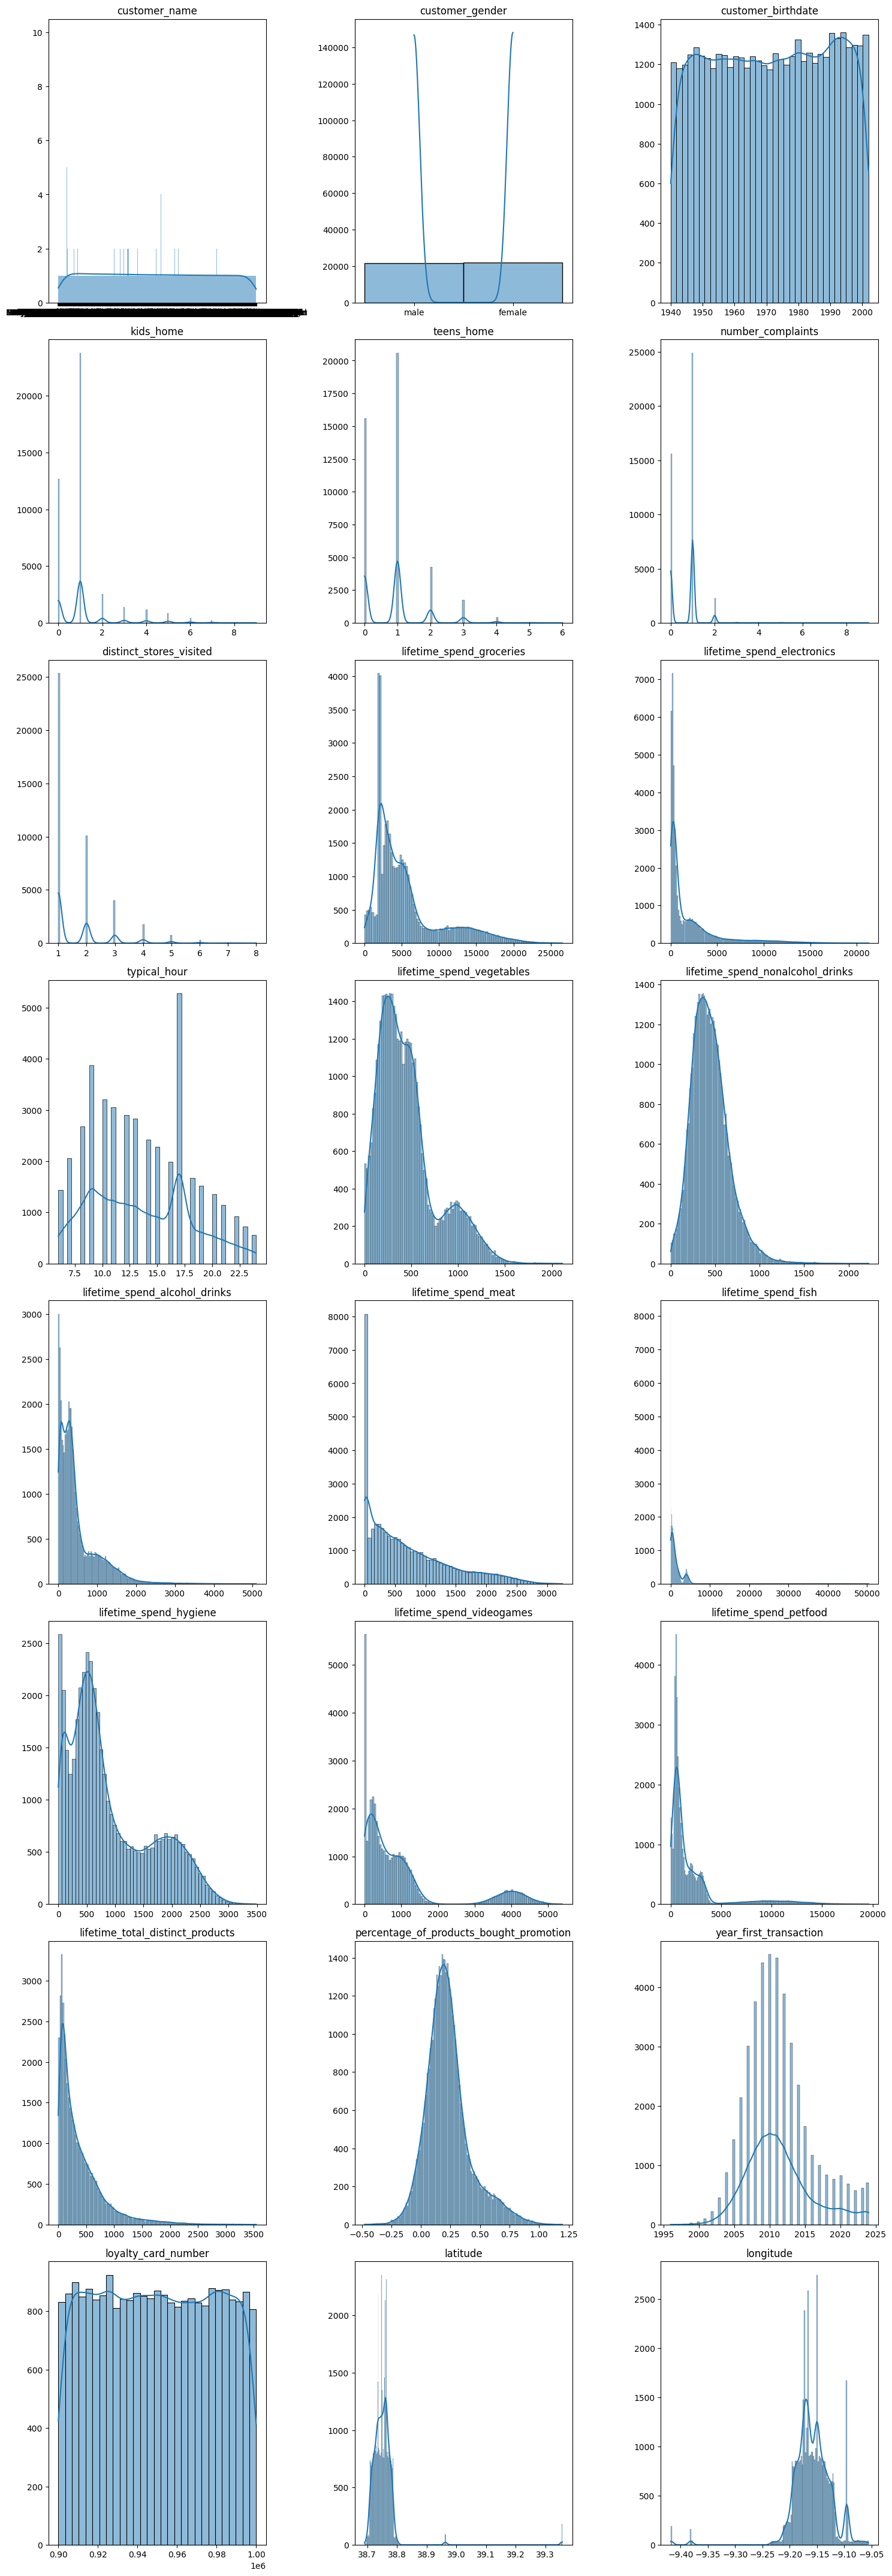

In [16]:
columns_to_visualize = customer_info.columns

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(columns_to_visualize)//3 + 1, ncols=3, figsize=(15, len(columns_to_visualize) * 2))

axes = axes.flatten()

# Loop through the columns and create a plot for each
for i, column in enumerate(columns_to_visualize):
    sns.histplot(customer_info[column], ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


# Dealing with some outliers (creating a cluster of just fishermen who spend a lot on fish)

In [3]:
customer_info[customer_info["lifetime_spend_fish"] >6000]

customer_name customer_gender  customer_birthdate  kids_home  \
customer_id                                                                     
48086          Charles`s Fishy            male 1966-09-04 09:18:00        0.0   
31838           Ursula`s Fishy          female 1963-09-20 15:37:00        0.0   
41519          Lindsay`s Fishy          female 1956-07-27 18:05:00        0.0   
41076            Carol`s Fishy          female 1942-07-18 08:53:00        0.0   
43120          Rosetta`s Fishy          female 1980-03-30 19:34:00        0.0   
...                        ...             ...                 ...        ...   
24463        Stephanie`s Fishy          female 1956-04-10 18:50:00        0.0   
12487          Derrick`s Fishy            male 1973-02-20 00:04:00        0.0   
14727            Tyler`s Fishy            male 1985-01-10 03:28:00        0.0   
46634           Kendra`s Fishy          female 1945-11-02 11:33:00        0.0   
20914             Anna`s Fishy          female 1994-08-26 03:33:00        0.0   

             teens_home  number_complaints  distinct_stores_visited  \
customer_id                                                           
48086               0.0                1.0                      1.0   
31838               0.0                1.0                      1.0   
41519               0.0                0.0                      1.0   
41076               0.0                0.0                      1.0   
43120               0.0                1.0                      1.0   
...                 ...                ...                      ...   
24463               0.0                1.0                      1.0   
12487               0.0                0.0                      1.0   
14727               0.0                1.0                      1.0   
46634               1.0                0.0                      1.0   
20914               0.0                1.0                      1.0   

             lifetime_spend_groceries  lifetime_spend_electronics  \
customer_id                                                         
48086                         14998.0                        49.0   
31838                         13837.0                       104.0   
41519                         14680.0                       167.0   
41076                         15110.0                       357.0   
43120                         16945.0                       200.0   
...                               ...                         ...   
24463                         16382.0                        77.0   
12487                         17416.0                       170.0   
14727                         14184.0                       158.0   
46634                         14685.0                        17.0   
20914                         14060.0                        13.0   

             typical_hour  ...  lifetime_spend_fish  lifetime_spend_hygiene  \
customer_id                ...                                                
48086                 7.0  ...              48432.0                    82.0   
31838                 9.0  ...              45651.0                   101.0   
41519                 9.0  ...              38525.0                   148.0   
41076                12.0  ...              34035.0                    80.0   
43120                 9.0  ...              39154.0                    20.0   
...                   ...  ...                  ...                     ...   
24463                17.0  ...              40584.0                   136.0   
12487                17.0  ...              40936.0                    72.0   
14727                 9.0  ...              40034.0                   101.0   
46634                17.0  ...              49025.0                   118.0   
20914                 9.0  ...              44585.0                    77.0   

             lifetime_spend_videogames  lifetime_spend_petfood  \
customer_id                                    

In [4]:
customer_info['Age'] = (pd.to_datetime('2024-05-01') - customer_info['customer_birthdate']).dt.days // 365.25
customer_info

customer_name customer_gender  customer_birthdate  \
customer_id                                                           
39634               David Frink            male 1964-05-15 22:34:00   
43460             Belinda Terry          female 1988-03-26 23:06:00   
23937             Evelyn Calico          female 1969-04-13 18:07:00   
2431                Ora Boggess          female 1941-06-15 03:26:00   
10090             Lonnie Hopson            male 2001-12-18 03:03:00   
...                         ...             ...                 ...   
48487           Amelia Crawford          female 1983-08-28 11:43:00   
24856              Silvia Ramos          female 1992-09-21 19:16:00   
21373             Addie Coronel          female 1994-02-20 05:58:00   
19527            Msc. Mary Ross          female 1989-08-06 16:39:00   
5120         Bsc. Milton Friend            male 1957-06-19 10:53:00   

             kids_home  teens_home  number_complaints  \
customer_id                                             
39634              1.0         1.0                1.0   
43460              1.0         0.0                1.0   
23937              0.0         1.0                1.0   
2431               0.0         0.0                0.0   
10090              0.0         0.0                0.0   
...                ...         ...                ...   
48487              1.0         1.0                0.0   
24856              1.0         1.0                1.0   
21373              0.0         0.0                0.0   
19527              1.0         0.0                1.0   
5120               2.0         0.0                2.0   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                            2.0                   18306.0   
43460                            2.0                    5015.0   
23937                            3.0                    3097.0   
2431                             1.0                   10825.0   
10090                            1.0                     697.0   
...                              ...                       ...   
48487                            1.0                    7189.0   
24856                            1.0                   11238.0   
21373                            1.0                    6059.0   
19527                            1.0                    3098.0   
5120                             1.0                    6869.0   

             lifetime_spend_electronics  typical_hour  ...  \
customer_id                                            ...   
39634                            7106.0          17.0  ...   
43460                            1334.0           8.0  ...   
23937                            4073.0          10.0  ...   
2431                              207.0          17.0  ...   
10090                             570.0           NaN  ...   
...                                 ...           ...  ...   
48487                            6293.0          17.0  ...   
24856                           11490.0          12.0  ...   
21373                             241.0          12.0  ...   
19527                             425.0           6.0  ...   
5120                             1554.0          10.0  ...   

             lifetime_spend_hygiene  lifetime_spend_videogames  \
customer_id                                                      
39634                        2174.0                     3946.0   
43460                        2115.0                     1028.0   
23937                        1306.0                     1504.0   
2431                           53.0                        0.0   
10090                         587.0                      223.0   
...                             ...                        ...   
48487                        1748.0                     4387.0   
24856                        1621.0                     3831.0   
21373                     

# Rebuilding loyalty card and gender variables

In [6]:
customer_info["children"] = customer_info["kids_home"] + customer_info["teens_home"]

In [7]:
customer_info["loyalty_card"] = customer_info["loyalty_card_number"].notnull().astype(int)

In [9]:
customer_info = pd.get_dummies(customer_info, columns= ["customer_gender"], drop_first= True)

In [10]:
customer_info["customer_gender_male"] = customer_info["customer_gender_male"].apply(lambda x: 1 if x == True else 0)

In [11]:
# Dataframe only for clustering and other preprocessing(for interpretation use customer_info)
customers = customer_info[~customer_info["customer_name"].str.contains("Fishy")]

In [12]:
out_fishermen = customer_info[customer_info["customer_name"].str.contains("Fishy")]

In [13]:
customers = customers.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "teens_home", "kids_home"])

# Scalling Variables

In [14]:
mm = MinMaxScaler().fit(customers)
customers_mm = mm.transform(customers)

In [15]:
customers_scalled = pd.DataFrame(customers_mm, columns = customers.columns, index = customers.index)

<Axes: >

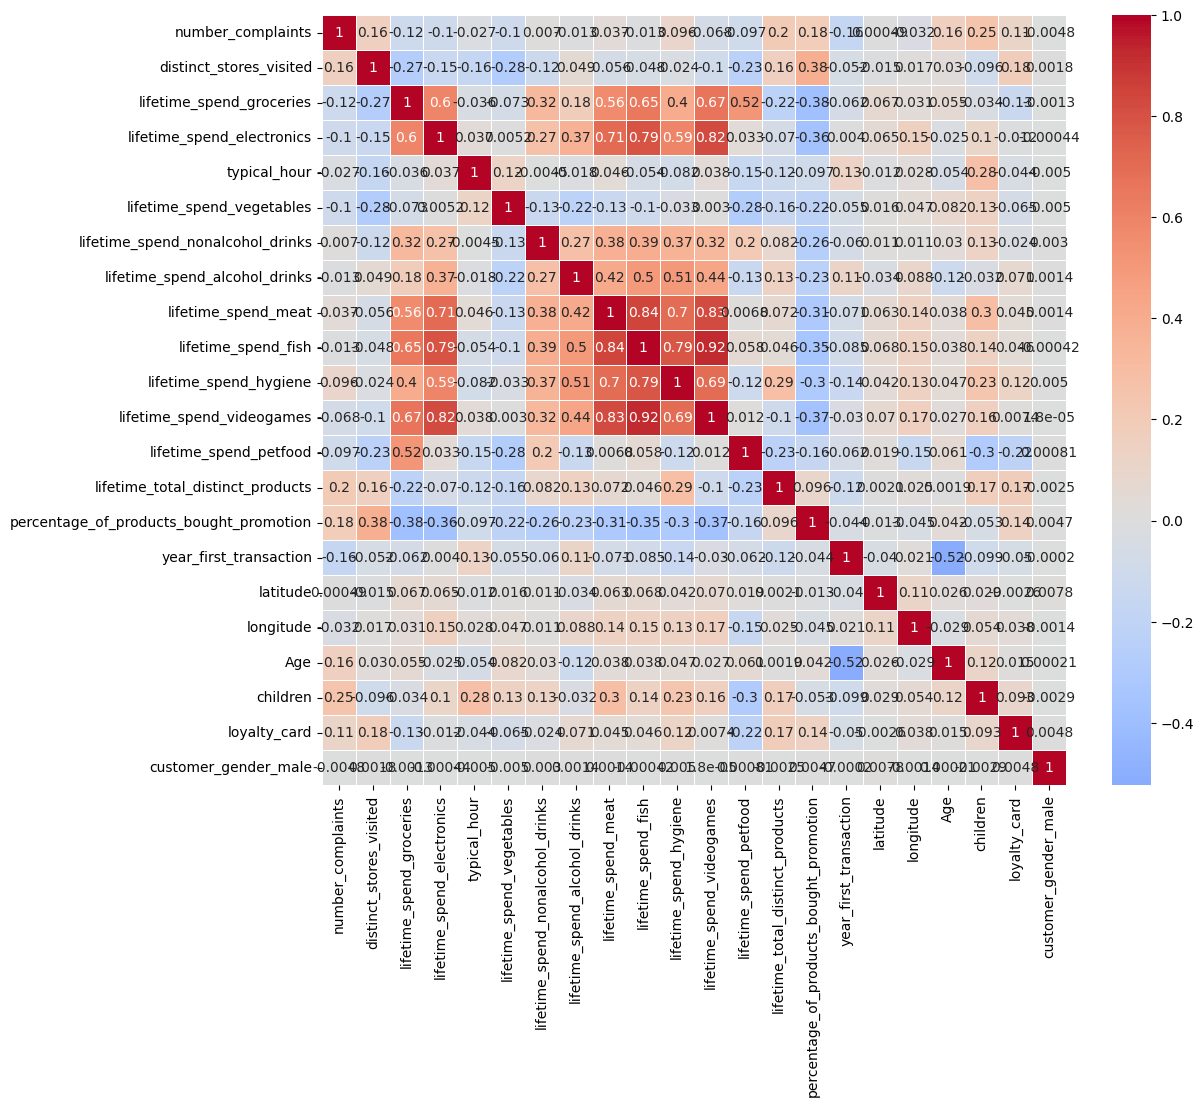

In [16]:
correlation_matrix = customers_scalled.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
    
# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

Fish with high correlation with a lot of variables so we tried to remove it but got worse results

# Imputing Missing Values

In [17]:
knn = KNNImputer(n_neighbors= 5).fit(customers_scalled)
customers_imputed = knn.transform(customers_scalled)

In [18]:
cust_prepoc= pd.DataFrame(customers_imputed, columns = customers.columns, index = customers.index)

In [19]:
cust_prepoc.head()

number_complaints  distinct_stores_visited  \
customer_id                                               
39634                 0.111111                 0.142857   
43460                 0.111111                 0.142857   
23937                 0.111111                 0.285714   
2431                  0.000000                 0.000000   
10090                 0.000000                 0.000000   

             lifetime_spend_groceries  lifetime_spend_electronics  \
customer_id                                                         
39634                        0.689440                    0.334038   
43460                        0.188875                    0.062709   
23937                        0.116639                    0.191463   
2431                         0.407691                    0.009731   
10090                        0.026250                    0.026795   

             typical_hour  lifetime_spend_vegetables  \
customer_id                                            
39634            0.611111                   0.229167   
43460            0.111111                   0.162879   
23937            0.222222                   0.142519   
2431             0.611111                   0.072443   
10090            0.611111                   0.003788   

             lifetime_spend_nonalcohol_drinks  lifetime_spend_alcohol_drinks  \
customer_id                                                                    
39634                                0.271583                       0.185229   
43460                                0.168165                       0.239049   
23937                                0.383094                       0.340012   
2431                                 0.113309                       0.011786   
10090                                0.014838                       0.556472   

             lifetime_spend_meat  lifetime_spend_fish  ...  \
customer_id                                            ...   
39634                   0.684923             0.732659  ...   
43460                   0.328615             0.347724  ...   
23937                   0.137231             0.423952  ...   
2431                    0.087692             0.027276  ...   
10090                   0.016615             0.031069  ...   

             lifetime_spend_petfood  lifetime_total_distinct_products  \
customer_id                                                             
39634                      0.128291                          0.009029   
43460                      0.101398                          0.724041   
23937                      0.102980                          0.361738   
2431                       0.211012                          0.019752   
10090                      0.003266                          0.001129   

             percentage_of_products_bought_promotion  year_first_transaction  \
customer_id                                                                    
39634                                       0.328503                0.500000   
43460                                       0.408523                0.642857   
23937                                       0.366693                0.464286   
2431                                        0.414270                0.392857   
10090                                       0.393475                1.000000   

             latitude  longitude       Age  children  loyalty_card  \
customer_id                                                          
39634        0.397470   0.478999  0.596774  0.153846           0.0   
43460        0.636523   0.413765  0.225806  0.076923           0.0   
23937        0.236664   0.389840  0.532258  0.076923           1.0   
2431         0.808462   0.472062  0.967742  0.000000           1.0   
10090        0.704482   0.323561  0.000000  0.000000           1.0   

             customer_gender_male  
customer_id                        
39634                         1.0  
43460                         0.0  
23937             

## Prepocessing of fishermen clusters

In [20]:
out_fishermen.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "kids_home", "teens_home"], inplace = True)

C:\Users\joaof\AppData\Local\Temp\ipykernel_13364\2672661084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_fishermen.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "kids_home", "teens_home"], inplace = True)


In [21]:
fishermen_mm = mm.transform(out_fishermen)
fishermen_scalled = pd.DataFrame(fishermen_mm, columns = out_fishermen.columns, index = out_fishermen.index)
knn = KNNImputer(n_neighbors= 5).fit(fishermen_scalled)
fishermen_imputed = knn.transform(fishermen_scalled)
fishermen_prepoc= pd.DataFrame(fishermen_imputed, columns = out_fishermen.columns, index = out_fishermen.index)

# KMeans clustering

In [22]:
# Calculating the distances in order to find out the optimal number of clusters
dispersion = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cust_prepoc)
    dispersion.append(kmeans.inertia_)

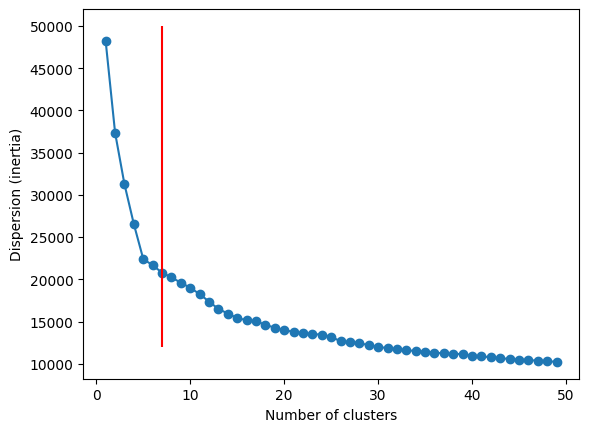

In [23]:
plt.plot(range(1, 50), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.vlines(7, 12000, 50000, color='red')
plt.show()

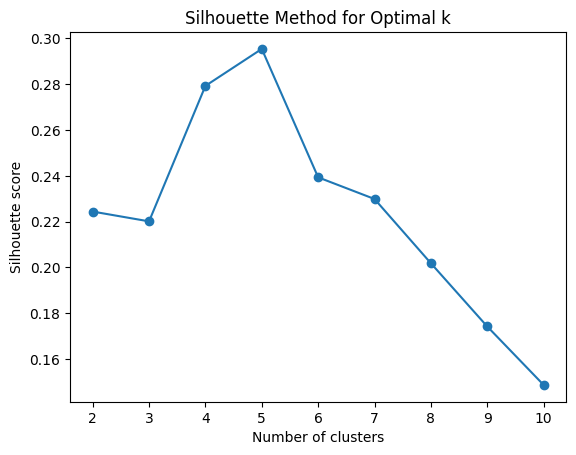

In [24]:
#Plotting the silhouette graph
plot_silhouette(cust_prepoc, max_clusters= 10)

In [25]:
# Create a K-means solution with 100 clusters to then apply the hierarchic clustering to obtain the best number of clusters
cust_copy = cust_prepoc.copy()
kmeans = KMeans(n_clusters=100, random_state=0).fit(cust_prepoc)
cust_copy['cluster_kmeans'] = kmeans.predict(cust_prepoc)

In [26]:
#From the dataset created above (that is a copy of the one after preprocessing) group by centroid 
#so we get the average per centroid to use in the agglomerative clustering

agg_knn = cust_copy.groupby("cluster_kmeans").mean()

In [27]:
# Create the hierarchical algorithm to find the best number of clusters
agg_clust = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None).fit(agg_knn)

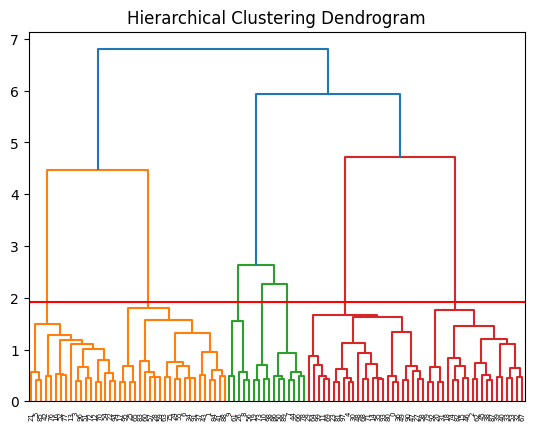

In [28]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.axhline(y = 1.925, color = 'r', linestyle = '-')
plt.show()

In [29]:
kmeans_final = KMeans(n_clusters = 7, random_state=0).fit(cust_prepoc)
cust_prepoc["kmeans_cluster"] = kmeans_final.predict(cust_prepoc)

In [30]:
cust_prepoc.head()

number_complaints  distinct_stores_visited  \
customer_id                                               
39634                 0.111111                 0.142857   
43460                 0.111111                 0.142857   
23937                 0.111111                 0.285714   
2431                  0.000000                 0.000000   
10090                 0.000000                 0.000000   

             lifetime_spend_groceries  lifetime_spend_electronics  \
customer_id                                                         
39634                        0.689440                    0.334038   
43460                        0.188875                    0.062709   
23937                        0.116639                    0.191463   
2431                         0.407691                    0.009731   
10090                        0.026250                    0.026795   

             typical_hour  lifetime_spend_vegetables  \
customer_id                                            
39634            0.611111                   0.229167   
43460            0.111111                   0.162879   
23937            0.222222                   0.142519   
2431             0.611111                   0.072443   
10090            0.611111                   0.003788   

             lifetime_spend_nonalcohol_drinks  lifetime_spend_alcohol_drinks  \
customer_id                                                                    
39634                                0.271583                       0.185229   
43460                                0.168165                       0.239049   
23937                                0.383094                       0.340012   
2431                                 0.113309                       0.011786   
10090                                0.014838                       0.556472   

             lifetime_spend_meat  lifetime_spend_fish  ...  \
customer_id                                            ...   
39634                   0.684923             0.732659  ...   
43460                   0.328615             0.347724  ...   
23937                   0.137231             0.423952  ...   
2431                    0.087692             0.027276  ...   
10090                   0.016615             0.031069  ...   

             lifetime_total_distinct_products  \
customer_id                                     
39634                                0.009029   
43460                                0.724041   
23937                                0.361738   
2431                                 0.019752   
10090                                0.001129   

             percentage_of_products_bought_promotion  year_first_transaction  \
customer_id                                                                    
39634                                       0.328503                0.500000   
43460                                       0.408523                0.642857   
23937                                       0.366693                0.464286   
2431                                        0.414270                0.392857   
10090                                       0.393475                1.000000   

             latitude  longitude       Age  children  loyalty_card  \
customer_id                                                          
39634        0.397470   0.478999  0.596774  0.153846           0.0   
43460        0.636523   0.413765  0.225806  0.076923           0.0   
23937        0.236664   0.389840  0.532258  0.076923           1.0   
2431         0.808462   0.472062  0.967742  0.000000           1.0   
10090        0.704482   0.323561  0.000000  0.000000           1.0   

             customer_gender_male  kmeans_cluster  
customer_id                                        
39634                         1.0               4  
43460                         0.0               2  
23937                         0.0               0  
2431                          0.0               6  
10090             

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


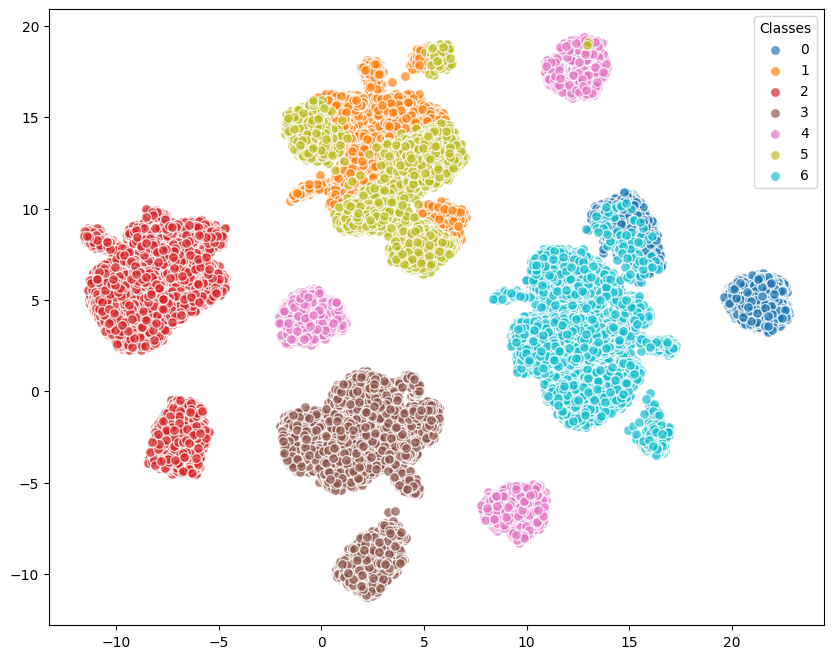

In [31]:
umap_object = umap.UMAP(n_neighbors=100, min_dist=0.7, random_state=0)
cust_prepoc = cust_prepoc.sort_index()
umap_embedding = umap_object.fit_transform(cust_prepoc.iloc[:, :-1])
visualize_dimensionality_reduction_umap(umap_embedding, cust_prepoc.iloc[:,-1].sort_index())

## Kmeans after kmeans

In [32]:
new_data = cust_prepoc[cust_prepoc["kmeans_cluster"].isin([1,5])]

In [33]:
new_data_copy = new_data.drop(columns="kmeans_cluster")

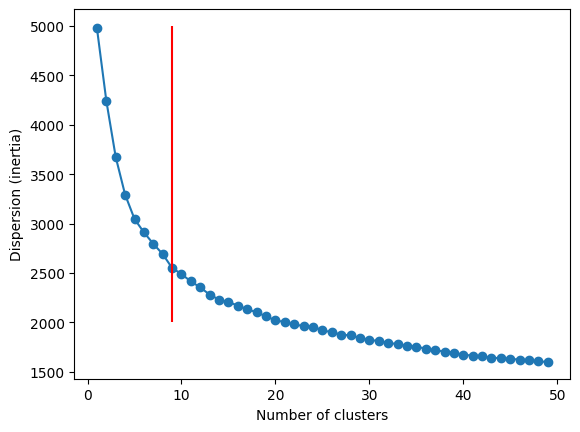

In [34]:
# Calculating the distances in order to find out the optimal number of clusters
dispersion = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(new_data_copy)
    dispersion.append(kmeans.inertia_)
    
# Plotting the elbow plot 
plt.plot(range(1, 50), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.vlines(9, 2000, 5000, color='red')
plt.show()

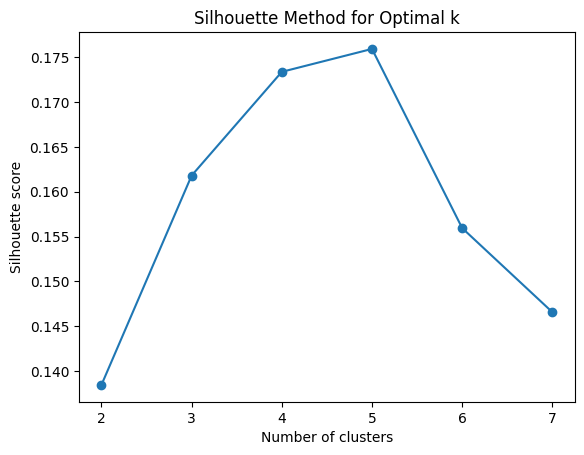

In [36]:
#Plotting the silhouette graph
plot_silhouette(new_data_copy, max_clusters= 7)

In [37]:
data = new_data_copy.copy()
kmeans = KMeans(n_clusters=100, random_state=0).fit(data)
data['cluster_kmeans'] = kmeans.predict(data)

In [38]:
agg_knn = data.groupby("cluster_kmeans").mean()

In [39]:
agg_clust = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None).fit(agg_knn)

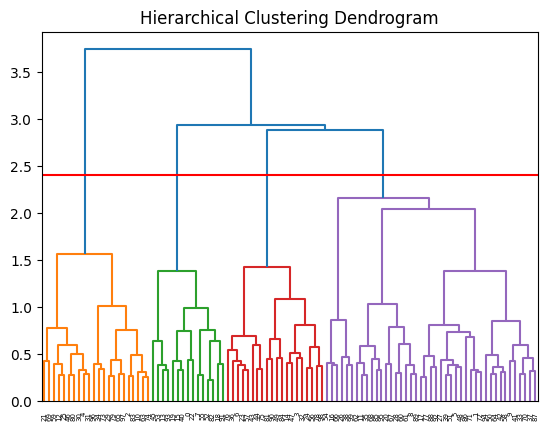

In [40]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.axhline(y = 2.4, color = 'r', linestyle = '-')
plt.show()

In [41]:
kmeans_final = KMeans(n_clusters = 4, random_state=0).fit(new_data_copy)
new_data_copy["kmeans_cluster"] = kmeans_final.predict(new_data_copy)

# UMAP

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


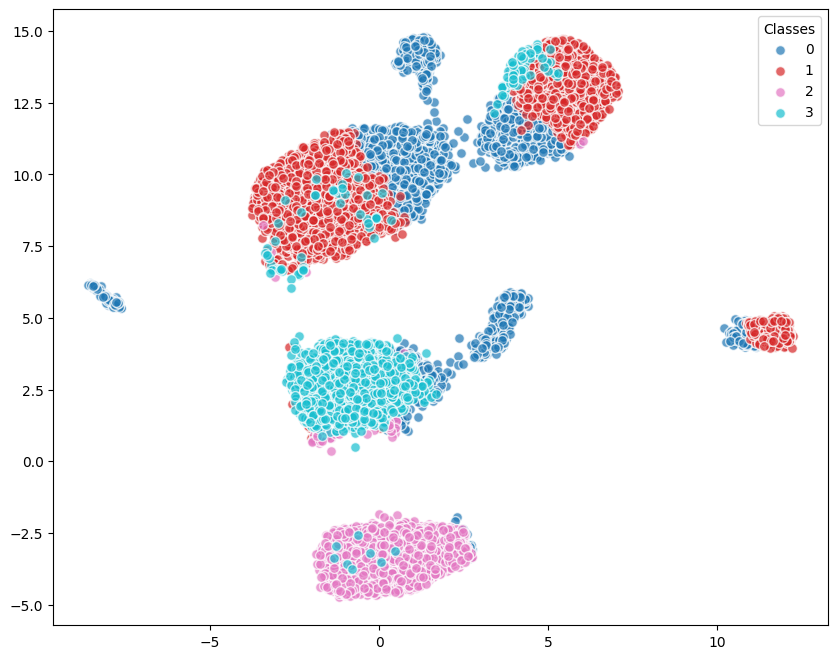

In [42]:
umap_object1 = umap.UMAP(n_neighbors=50, min_dist=0.3, random_state=0)
new_data_copy = new_data_copy.sort_index()
umap_embedding1 = umap_object1.fit_transform(new_data_copy.iloc[:, :-1])
visualize_dimensionality_reduction_umap(umap_embedding1, new_data_copy.iloc[:,-1].sort_index())

# DBScan

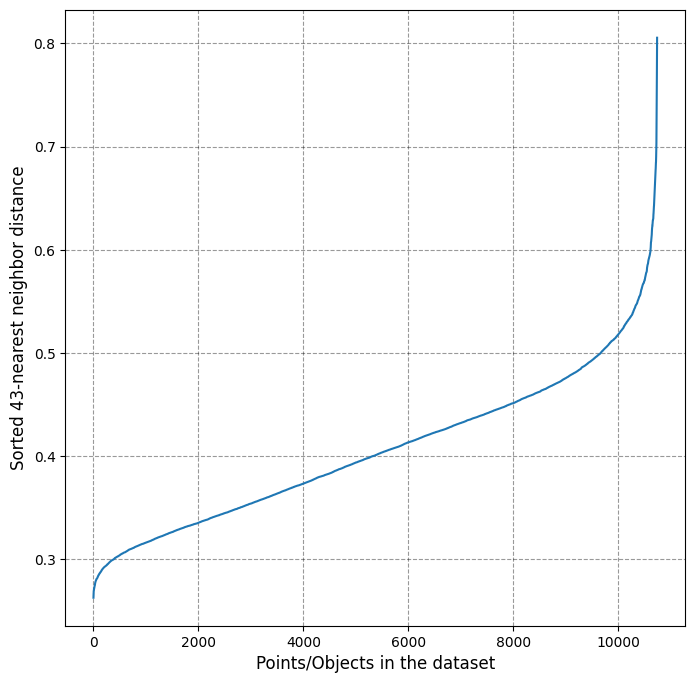

In [46]:
new_data = cust_prepoc[cust_prepoc["kmeans_cluster"].isin([1,5])]
new_data_copy = new_data.drop(columns="kmeans_cluster")
k = 2 * new_data_copy.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=new_data_copy, k=k)

In [47]:
new_data_copy['dbscan_clustering'] = DBSCAN(
    eps=0.6, min_samples=k
    ).fit_predict(new_data_copy)

In [48]:
new_data_copy['dbscan_clustering'].value_counts()

dbscan_clustering
 0    10742
-1        2
Name: count, dtype: int64

## UMAP

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


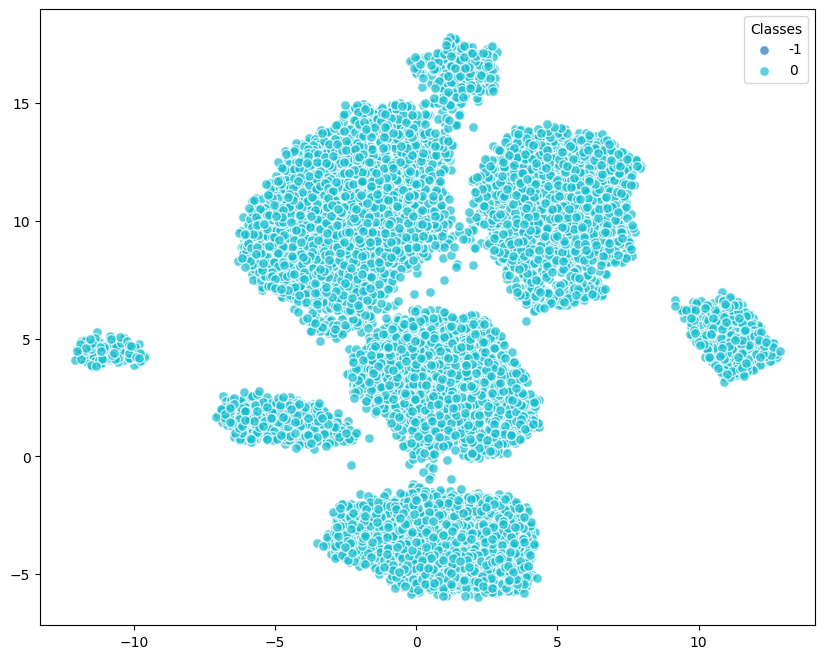

In [49]:
umap_object_2 = umap.UMAP(n_neighbors=15, min_dist=0.7, random_state=0)
new_data_copy = new_data_copy.sort_index()
umap_embedding_2 = umap_object_2.fit_transform(new_data_copy.iloc[:, :-1])
visualize_dimensionality_reduction_umap(umap_embedding_2, new_data_copy.iloc[:,-1])

# Analysis of the clusters

In [50]:
cust_kmeans_clusters = cust_prepoc[["kmeans_cluster"]]
og_cluster = customer_info.merge(cust_kmeans_clusters, on='customer_id', how= "left")
og_cluster["kmeans_cluster"] = og_cluster["kmeans_cluster"].fillna(7)

In [51]:
mean_clusters = og_cluster.groupby("kmeans_cluster").agg({
    'kids_home': np.mean,
    'teens_home': np.mean,
    'number_complaints': np.mean,
    'distinct_stores_visited': np.mean,
    'lifetime_spend_groceries': np.mean,
    'lifetime_spend_electronics': np.mean,
    'typical_hour': np.mean,
    'lifetime_spend_vegetables': np.mean,
    'lifetime_spend_nonalcohol_drinks': np.mean,
    'lifetime_spend_alcohol_drinks': np.mean,
    'lifetime_spend_meat': np.mean,
    'lifetime_spend_fish': np.mean,
    'lifetime_spend_hygiene': np.mean,
    'lifetime_spend_videogames': np.mean,
    'lifetime_spend_petfood': np.mean,
    'lifetime_total_distinct_products': np.mean,
    'percentage_of_products_bought_promotion': np.mean,
    'year_first_transaction': np.mean,
    'latitude': np.mean,
    'longitude': np.mean,
    'Age': np.mean,
    'loyalty_card': np.mean,
    'customer_gender_male': np.mean
})

C:\Users\joaof\AppData\Local\Temp\ipykernel_13364\3530152762.py:1: FutureWarning: The provided callable <function mean at 0x000001784B6CE0C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_clusters = og_cluster.groupby("kmeans_cluster").agg({


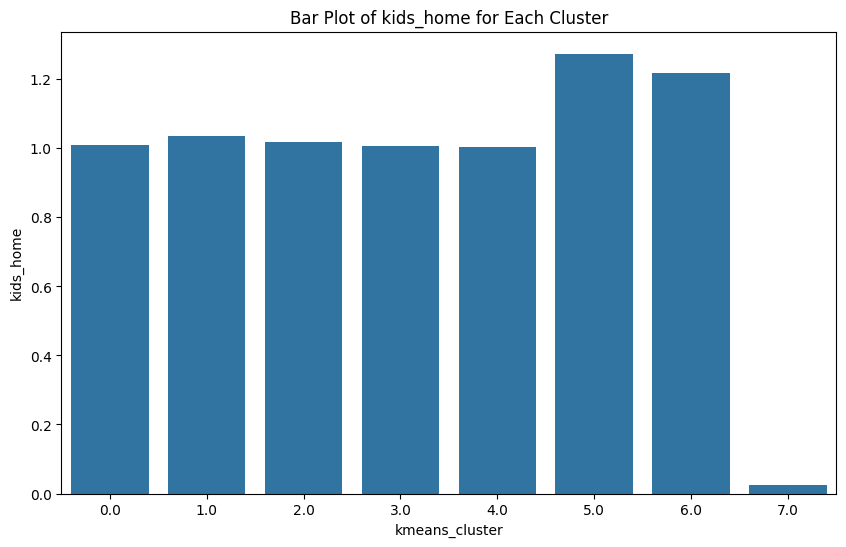

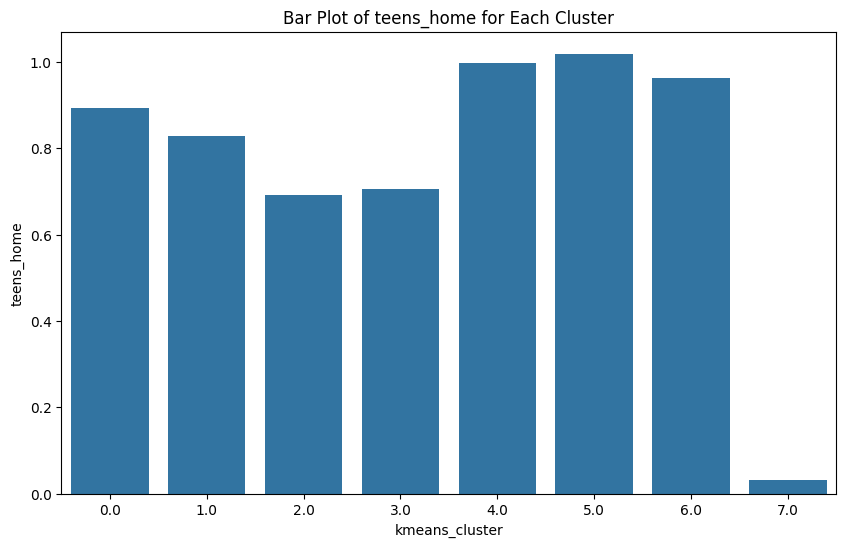

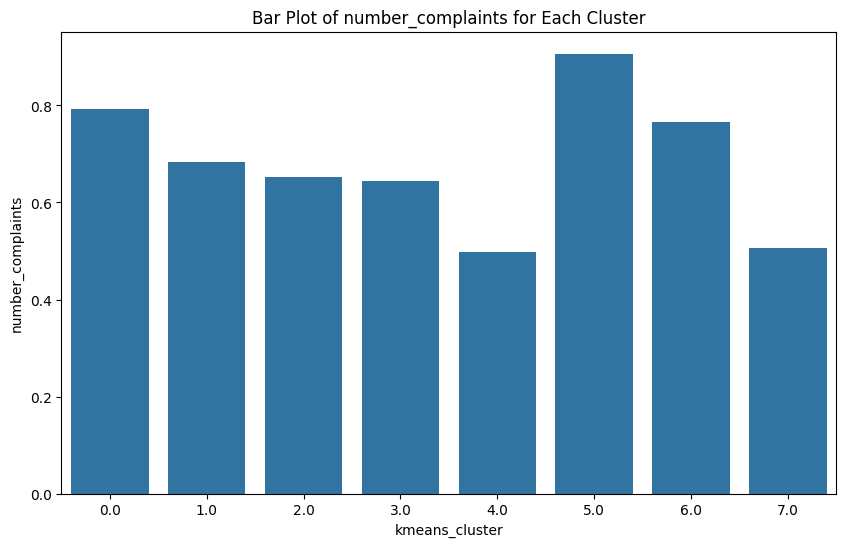

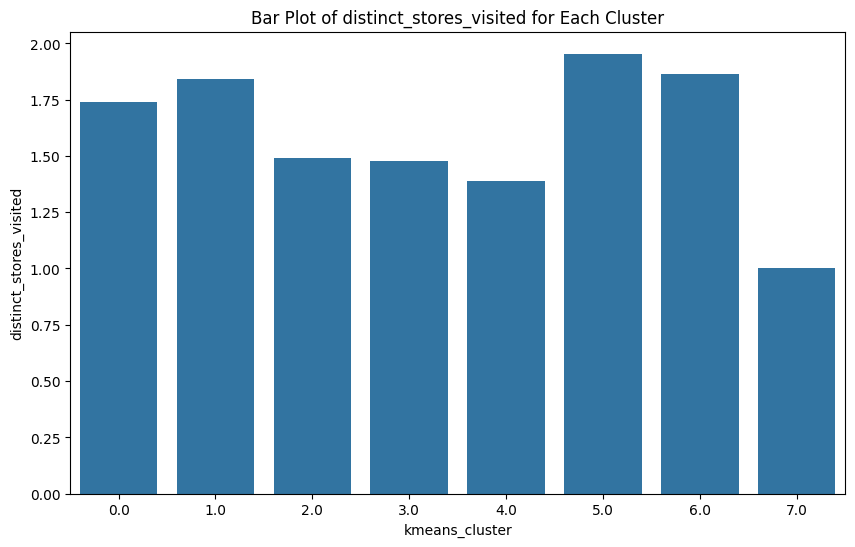

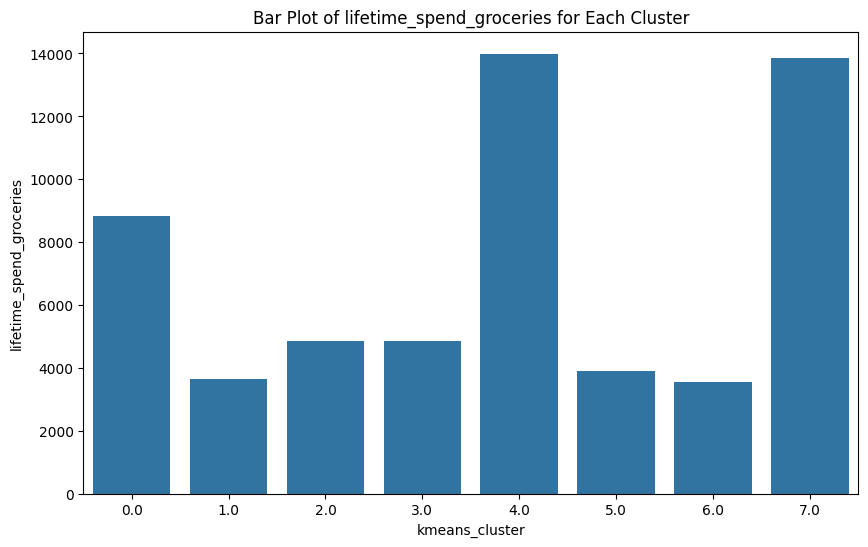

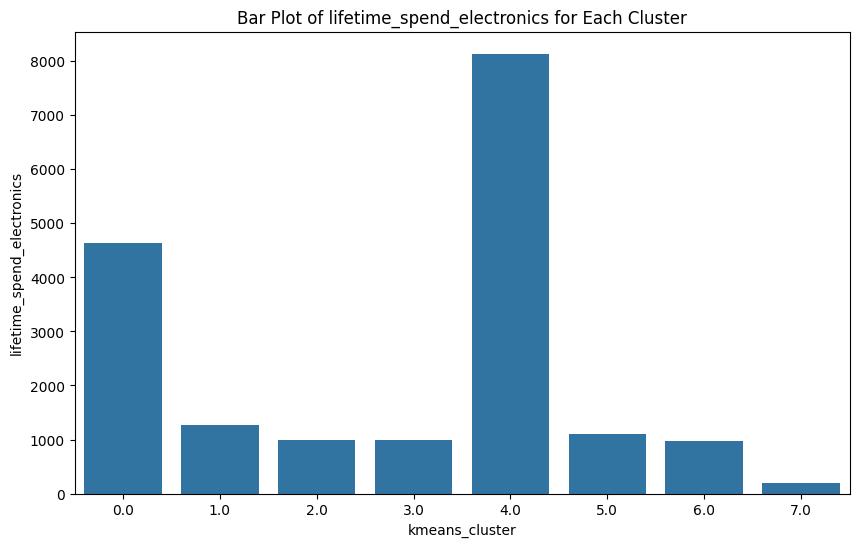

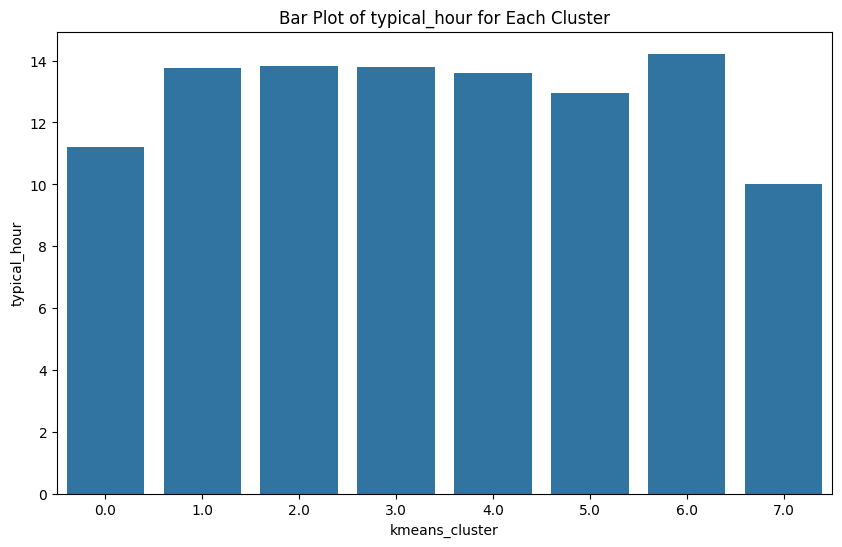

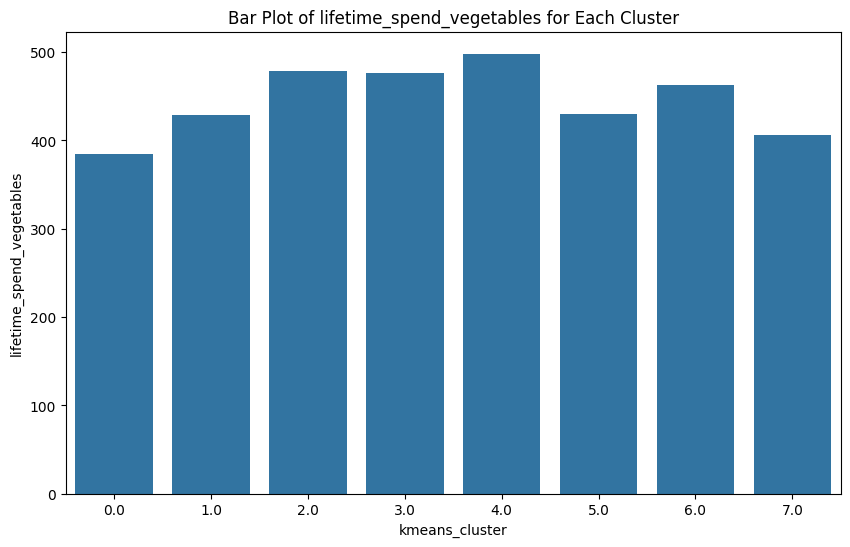

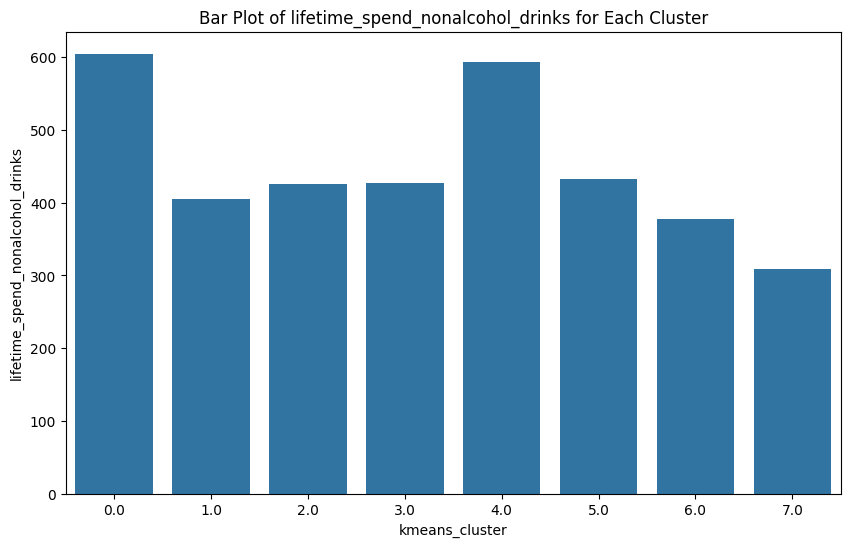

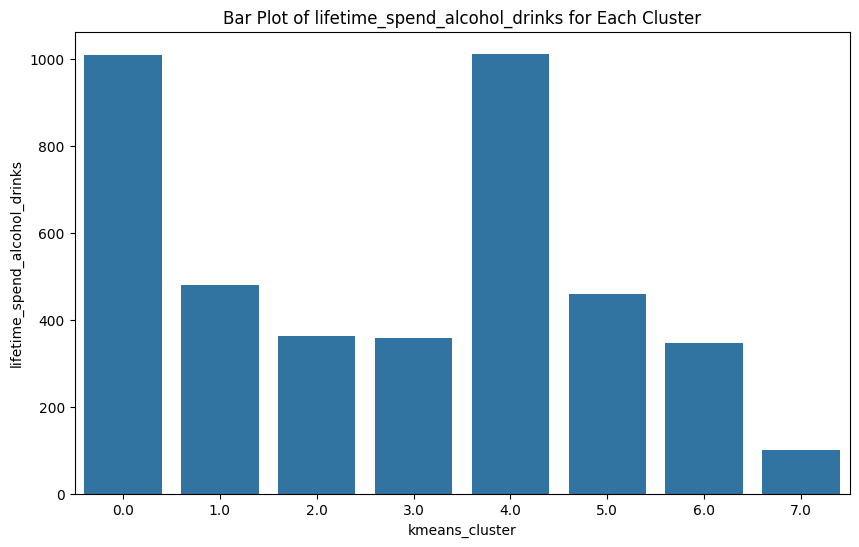

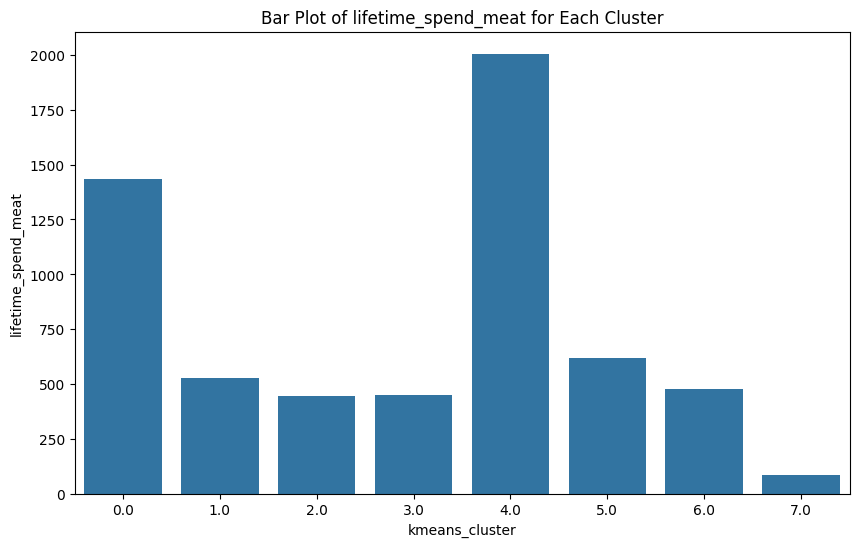

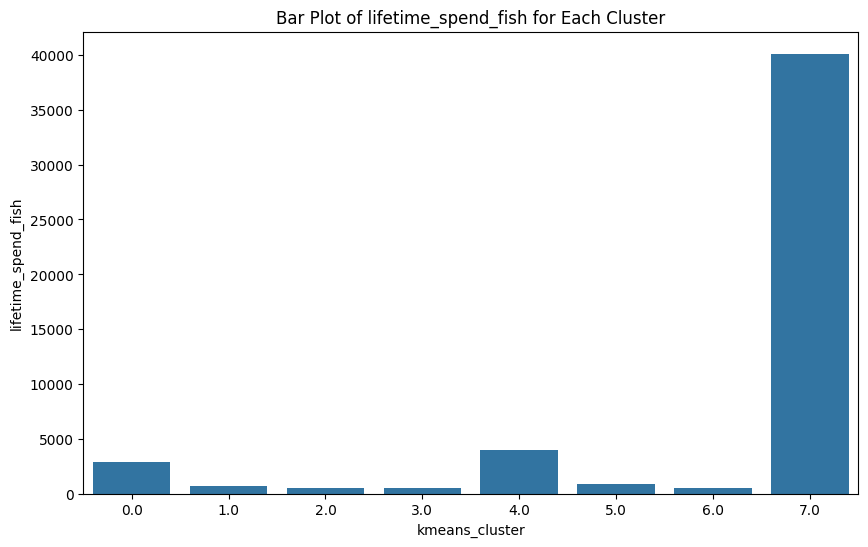

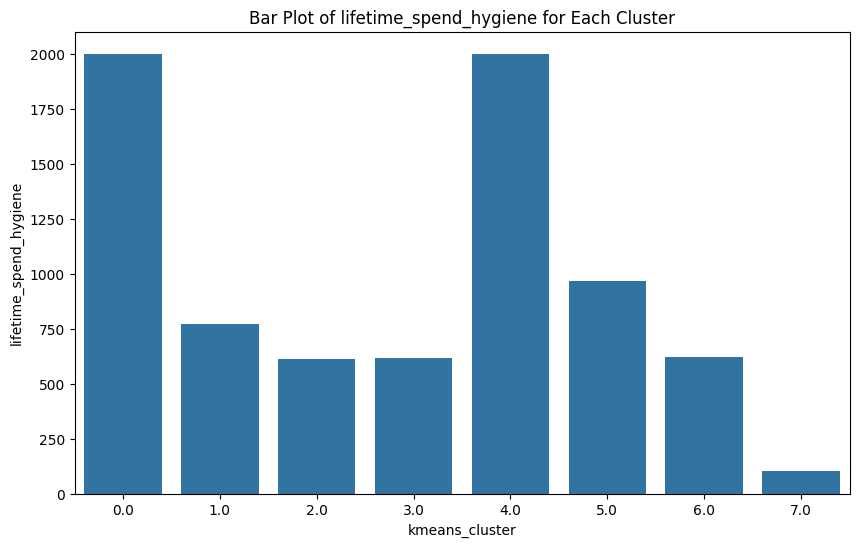

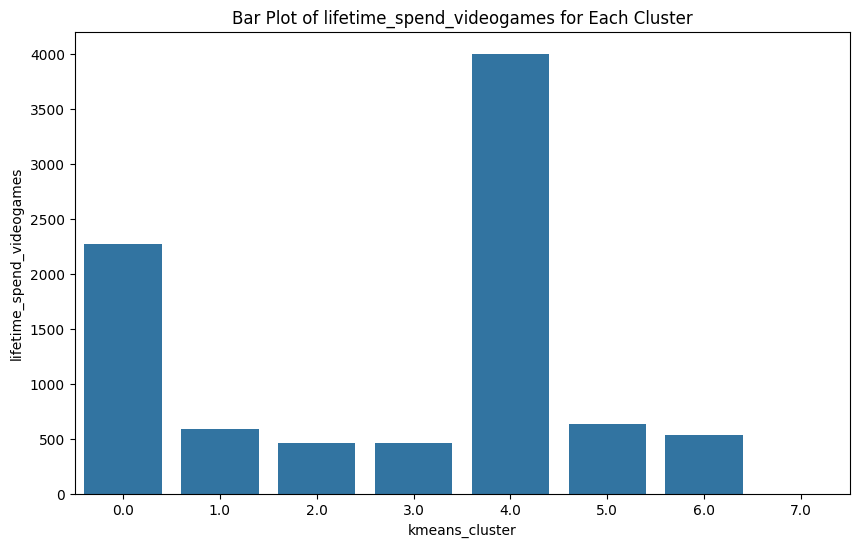

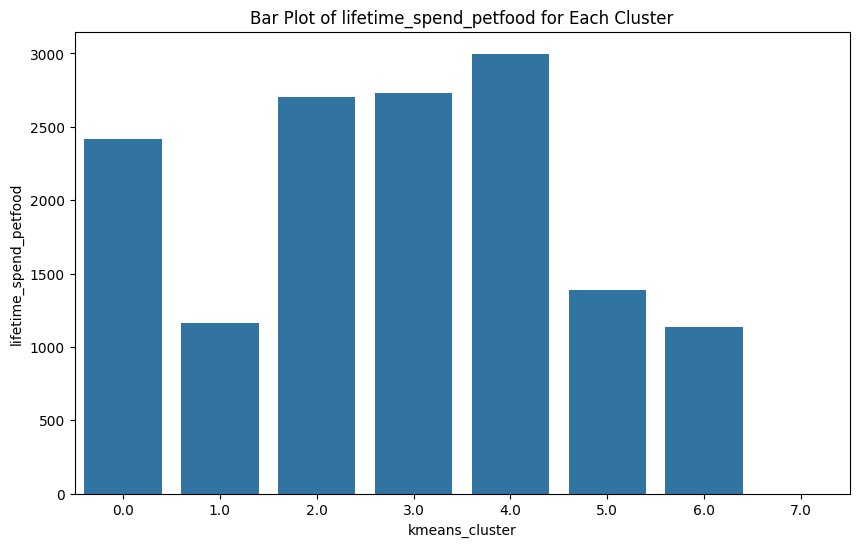

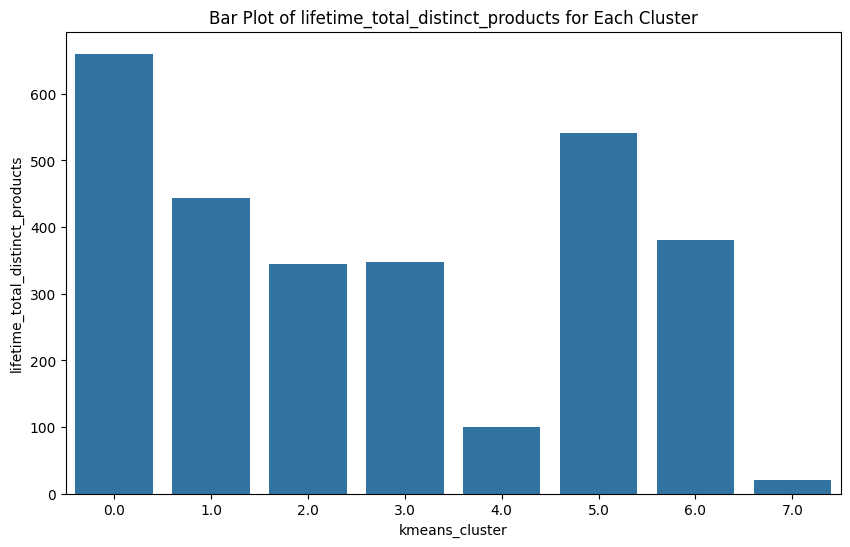

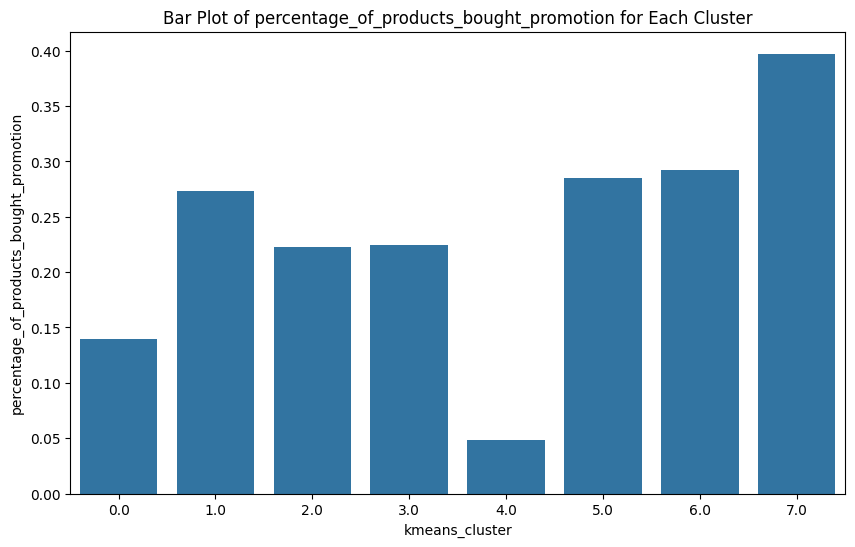

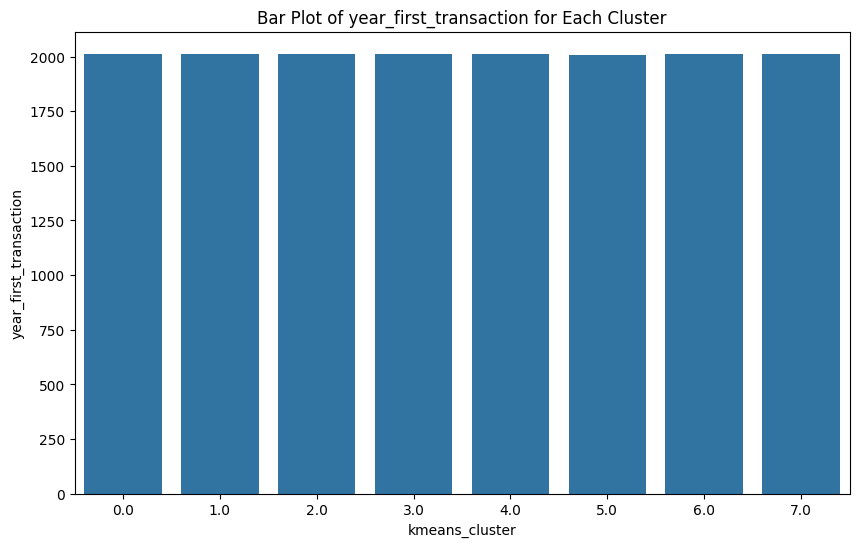

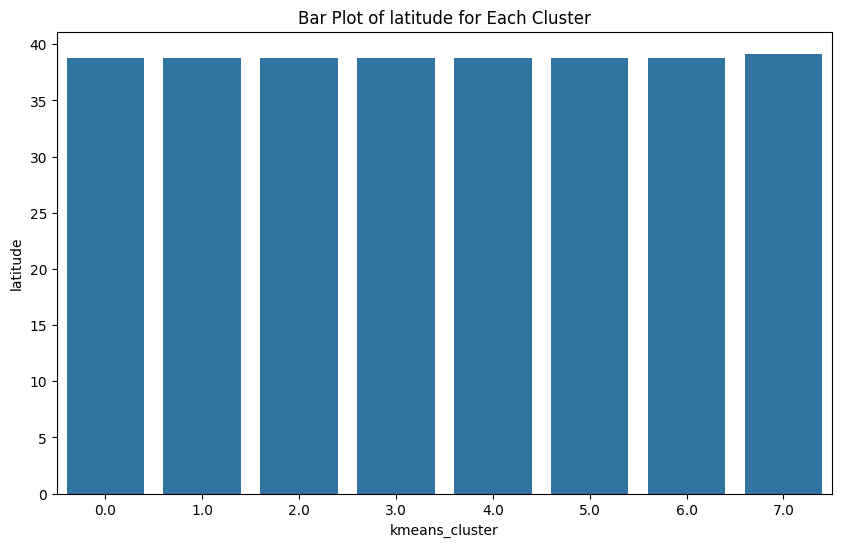

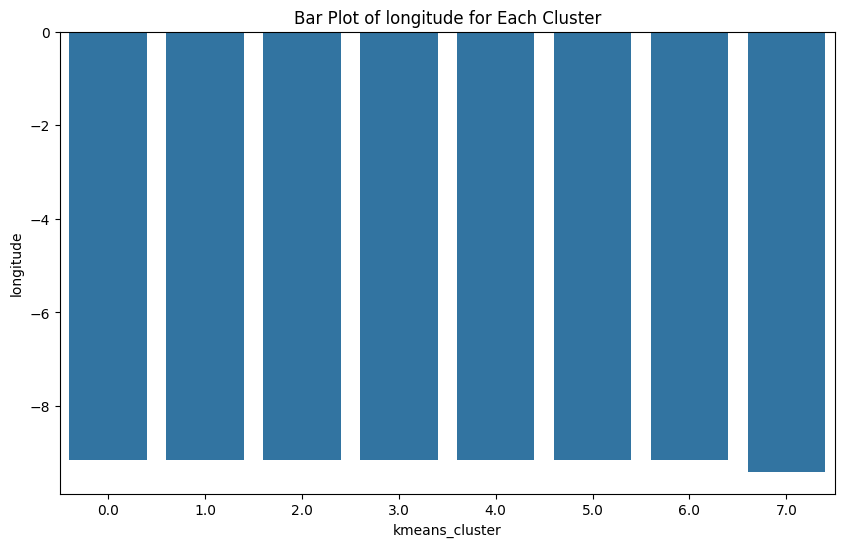

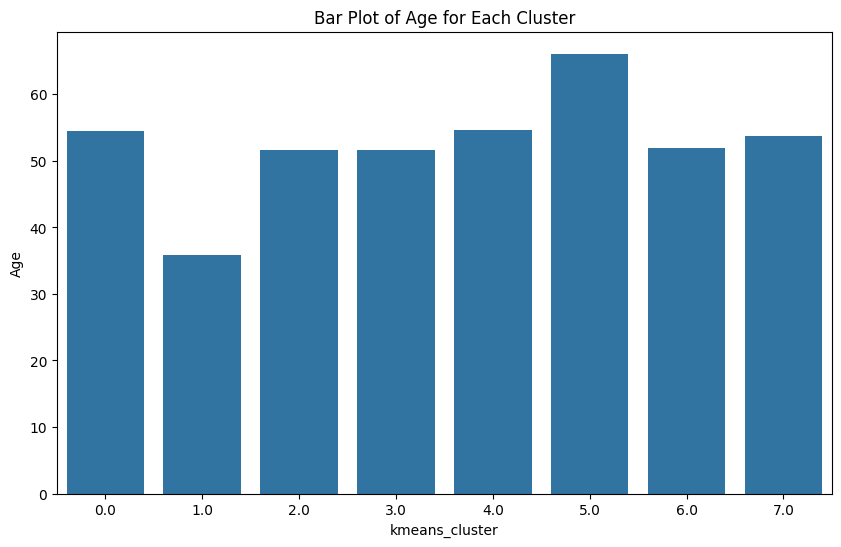

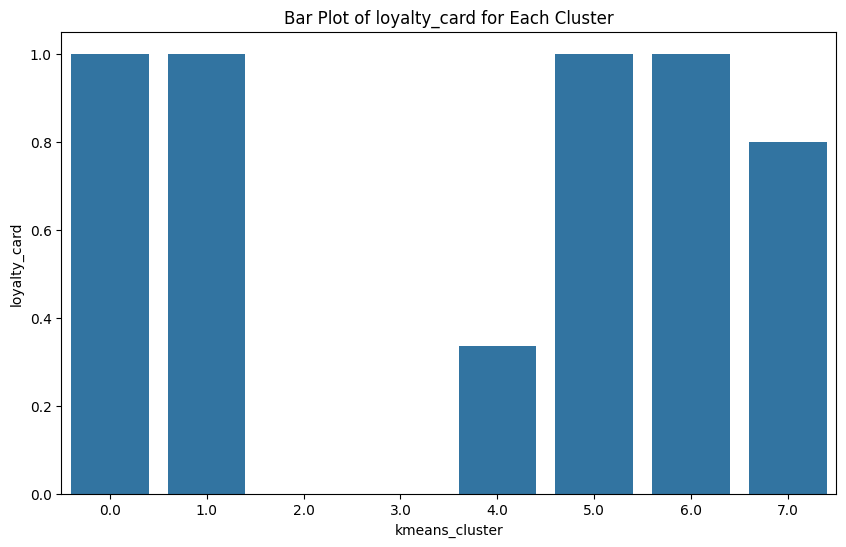

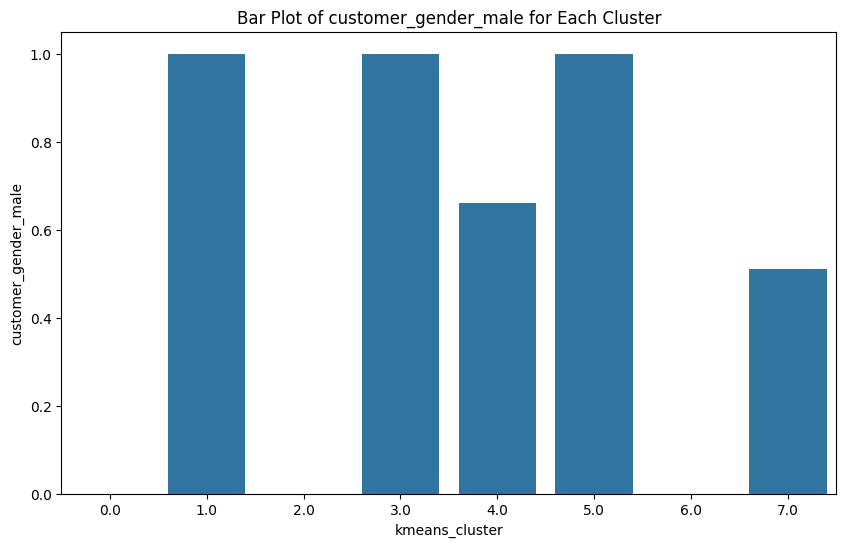

In [52]:
for column in mean_clusters.columns:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=mean_clusters.index, y=column, data=mean_clusters)
        plt.title(f'Bar Plot of {column} for Each Cluster')
        plt.show()

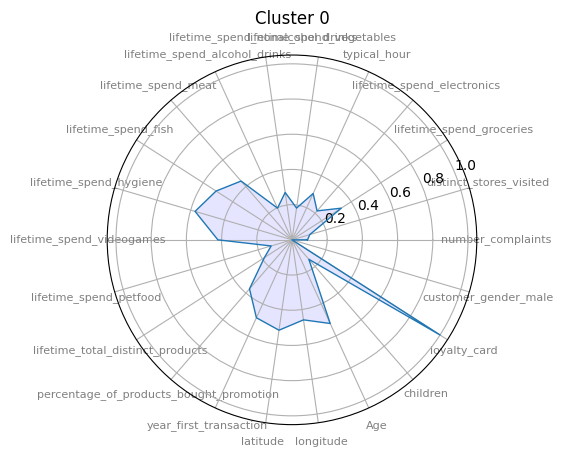

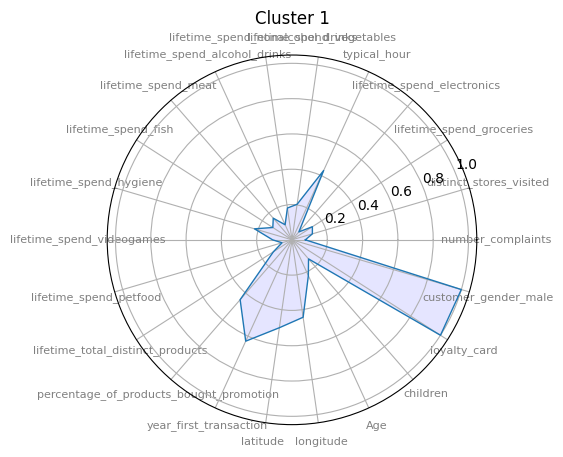

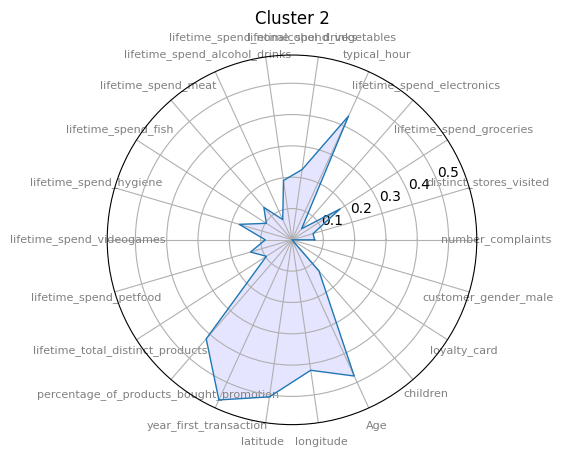

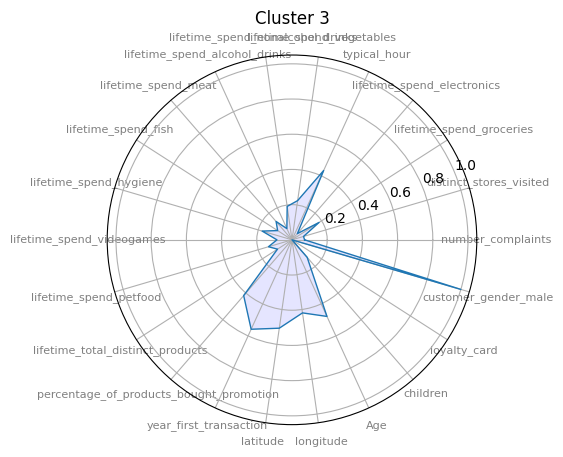

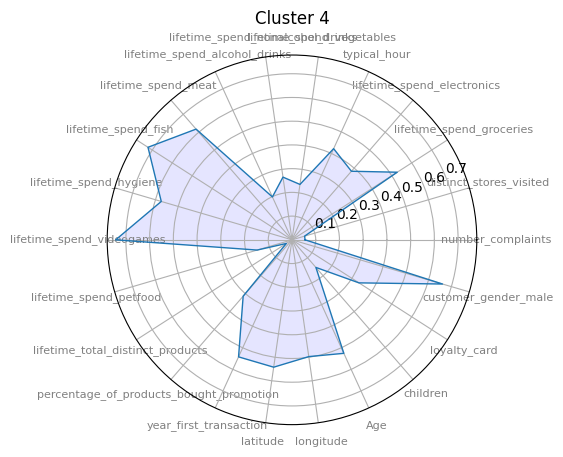

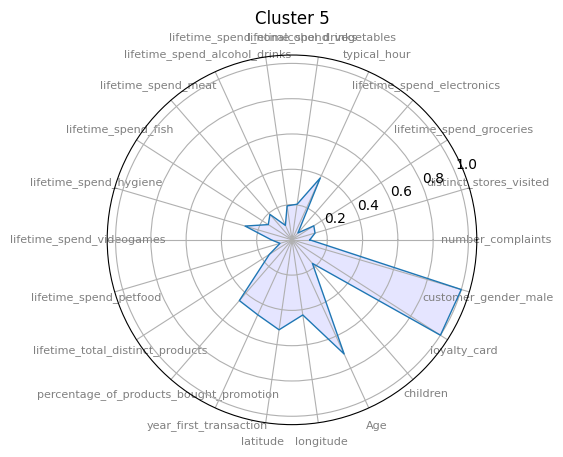

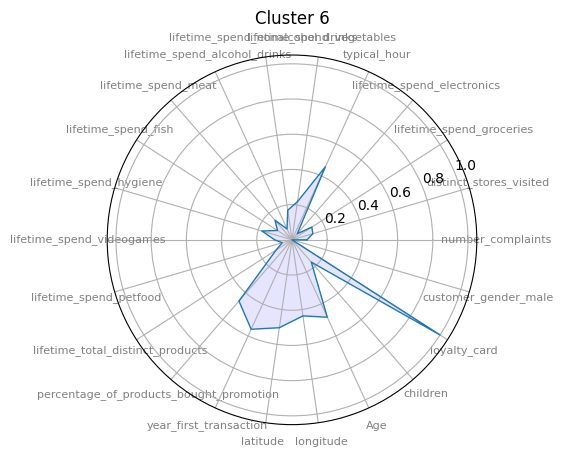

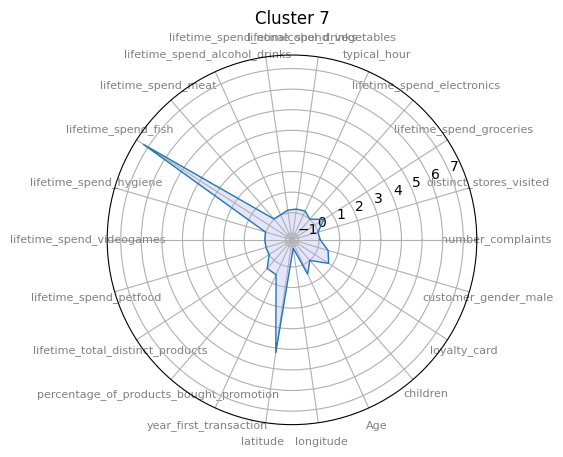

In [53]:
fishermen_prepoc["kmeans_cluster"] = None
fishermen_prepoc["kmeans_cluster"] = fishermen_prepoc["kmeans_cluster"].apply(lambda x: 7)
mean_standard_clusters = pd.concat([cust_prepoc.iloc[:-2],fishermen_prepoc]).groupby("kmeans_cluster").mean()


# Select the columns to be visualized
categories = mean_standard_clusters.columns.tolist()

# Create a radar chart for each cluster
for cluster in mean_standard_clusters.index.tolist():
    create_radar_chart(mean_standard_clusters, cluster, categories)

In [54]:
mean_clusters

kids_home  teens_home  number_complaints  \
kmeans_cluster                                             
0.0              1.007615    0.893827           0.792073   
1.0              1.035117    0.828076           0.682431   
2.0              1.016860    0.692453           0.651570   
3.0              1.005215    0.704709           0.644189   
4.0              1.002144    0.998072           0.497128   
5.0              1.273528    1.019258           0.906884   
6.0              1.218664    0.963550           0.766586   
7.0              0.023560    0.031250           0.506562   

                distinct_stores_visited  lifetime_spend_groceries  \
kmeans_cluster                                                      
0.0                            1.737593               8838.254370   
1.0                            1.840017               3647.026117   
2.0                            1.490086               4845.448735   
3.0                            1.477968               4856.425687   
4.0                            1.388458              13994.897291   
5.0                            1.954698               3900.867363   
6.0                            1.864087               3563.576089   
7.0                            1.000000              13854.639175   

                lifetime_spend_electronics  typical_hour  \
kmeans_cluster                                             
0.0                            4629.751055     11.196613   
1.0                            1269.461334     13.775562   
2.0                             997.291178     13.827081   
3.0                             996.305155     13.788524   
4.0                            8135.859600     13.609058   
5.0                            1099.130412     12.936216   
6.0                             973.493226     14.225951   
7.0                             187.306701     10.013405   

                lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
kmeans_cluster                                                                
0.0                            384.641341                        604.817963   
1.0                            428.245326                        404.909406   
2.0                            478.745729                        425.667736   
3.0                            476.155669                        426.790669   
4.0                            498.188838                        593.771967   
5.0                            430.304750                        432.437104   
6.0                            462.508253                        377.652856   
7.0                            405.793194                        308.463918   

                lifetime_spend_alcohol_drinks  ...  lifetime_spend_videogames  \
kmeans_cluster                                 ...                              
0.0                               1008.084388  ...                2269.311935   
1.0                                478.618649  ...                 592.039584   
2.0                                361.832079  ...                 459.767428   
3.0                                357.527029  ...                 461.120281   
4.0                               1011.739458  ...                4004.431567   
5.0                                458.465857  ...                 632.156084   
6.0                                346.667984  ...                 528.642244   
7.0                                 99.829897  ...                   0.000000   

                lifetime_spend_petfood  lifetime_total_distinct_products  \
kmeans_cluster                                                             
0.0                        2417.421037                        660.106691   
1.0                        1159.919404                        443.943889   
2.0                        2702.914744                        345.013942   
3.0                        2729.228270                        347.075505   
4.0                        2998.973380                        100